In [1]:
import os
from os import path
import re

from matplotlib import pyplot as plt
import numpy as np
from networkx.linalg import laplacian_spectrum
from networkx.linalg import adjacency_spectrum

import cnet
import utils as utl
import imp

# Выбор устойчивых уровней для серии магнитограмм

Серию магнитограмм нужно обрабатывать как-то единообразно, для этого нужно выбрать какие-то "близкие" бета-устойчивые уровни.

Например, для первого изображения может иметься уровень $(s, \beta) = (30, 5)$, при этом для остальных изображений его может не быть, или он может быть только при большом сглаживании, что не есть хорошо (например $(90, 5)$). Как вариант, можно выбирать следующий устойчивый уровень таким образом, чтобы он был как можно ближе к предыдущему (например, к $(30, 5)$). Например, если нет $(30, 5)$, но есть $(20, 4), (25, 7), (40, 6)$, то можно, скажем, взять $(25, 7)$.

Первый устойчивый уровень также можно выбирать из каких-то эвристических соображений. Допустим, взять 5-устойчивый уровень и посмотреть среди серии изображений на каком масштабе $s$ наиболее часто он встречается и взять эту пару $(s, \beta)$ за первый устойчивый уровень.

# Поиск изображений

In [2]:
imagesdir = 'images/AR11158'
imagepaths, images_num = utl.find_images(imagesdir)

Found images: 165


# Вспышки

In [3]:
flares = utl.parse_flares(path.join(imagesdir, 'flares.txt'))
print('Flares: %d\n' % len(flares))
for date, (flcl, _, _) in flares.items():
    print(date, flcl)

Всего вспышек: 3

2011-02-15 X2.3
2011-02-13 M6.6
2011-02-18 M6.6


# Карта частоты встречаемости пар $(s, \beta)$ среди набора магнитограмм

В каждой клетке не доля, а количество случаев, в которых встречается пара.

In [4]:
# Множество уникальных значений уровней устойчивости.
uniq_betas = set()
# Статистика для отрисовки тепловой карты частот встречаемости пар (s, beta).
stats = {}
# Список пар (s, beta) для каждого изображения.
image_betas = []
# Общее число устойчивых уровней по всем изображениям.
total_scales_num = 0
# Какой уровень устойчивости выбираем.
beta_level = 6
# Выбранные уровни для каждого изображения.
selected_levels = []
# Графы, построенные по каждому изображению.
graphs = []
# Спектры, построенные по каждому изображению
spectra = []

for i, filepath in enumerate(imagepaths):
    print('%d/%d' % (i+1, images_num), end=' ')
    log, components, beta_scales, betas = cnet.cpt_stable_log(filepath, ss_sigma=1.6)
    image_betas.append(list(zip(beta_scales, betas)))
    total_scales_num += len(betas)
    
    # Набираем статистику и уникальные значения устойчивости.
    for k, beta in zip(beta_scales, betas):
        if k not in stats:
            stats[k] = {}
        if beta not in stats[k]:
            uniq_betas.add(beta)
            stats[k][beta] = 0
        stats[k][beta] += 1

    idx = cnet.select_level(beta_level, betas)
    selected_levels.append((beta_scales[idx], betas[idx]))
    
    lap = log[idx]
    minima, maxima = cnet.cpt_keypoints(lap, replace_clusters=True)
    edges = cnet.cpt_criticalnet(lap, minima, maxima)
    
    graph = cnet.mk_graph(edges)
    graphs.append(graph)
    sp = laplacian_spectrum(graph)
    
    spectra.append(sp)

del log, lap, components

1/165 2/165 3/165 4/165 5/165 6/165 7/165 8/165 9/165 10/165 11/165 12/165 13/165 14/165 15/165 16/165 17/165 18/165 19/165 20/165 21/165 22/165 23/165 24/165 25/165 26/165 27/165 28/165 29/165 30/165 31/165 32/165 33/165 34/165 35/165 36/165 37/165 38/165 39/165 40/165 41/165 42/165 43/165 44/165 45/165 46/165 47/165 48/165 49/165 50/165 51/165 52/165 53/165 54/165 55/165 56/165 57/165 58/165 59/165 60/165 61/165 62/165 63/165 64/165 65/165 66/165 67/165 68/165 69/165 70/165 71/165 72/165 73/165 74/165 75/165 76/165 77/165 78/165 79/165 80/165 81/165 82/165 83/165 84/165 85/165 86/165 87/165 88/165 89/165 90/165 91/165 92/165 93/165 94/165 95/165 96/165 97/165 98/165 99/165 100/165 101/165 102/165 103/165 104/165 105/165 106/165 107/165 108/165 109/165 110/165 111/165 112/165 113/165 114/165 115/165 116/165 117/165 118/165 119/165 120/165 121/165 122/165 123/165 124/165 125/165 126/165 127/165 128/165 129/165 130/165 131/165 132/165 133/165 134/165 135/165 136/165 137/165 138/165 139/

In [5]:
scales = sorted(stats.keys())
betas = sorted(list(uniq_betas))
rates = np.zeros((len(scales), len(betas)))
scales_idx = {s: i for i, s in enumerate(scales)}
betas_idx = {b: i for i, b in enumerate(betas)}

for s, data in stats.items():
    for b, rate in data.items():
        rates[scales_idx[s], betas_idx[b]] += rate
# rates /= total_scales_num

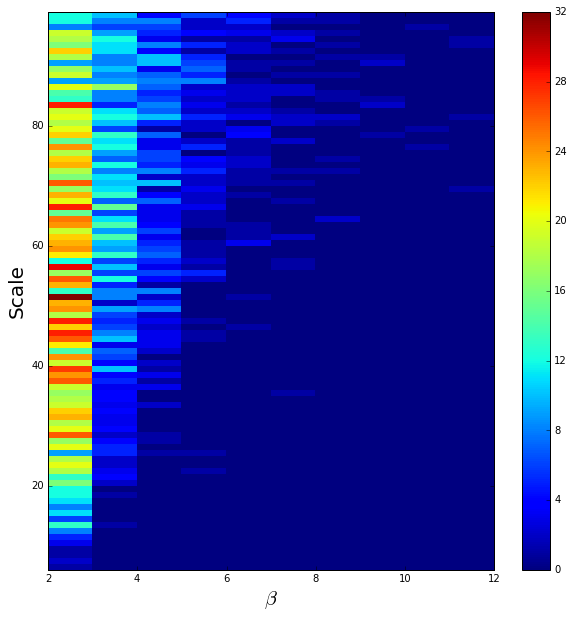

In [6]:
plt.figure(figsize=(10, 10))
plt.subplot()
plt.pcolor(betas, scales, rates, cmap=plt.cm.jet)
plt.colorbar()
plt.axis([min(betas), max(betas), min(scales), max(scales)])
plt.ylabel('Scale', fontsize=20)
plt.xlabel(r'$\beta$', fontsize=20)
plt.show()

# Как часто встречается $\beta$-й уровень устойчивости

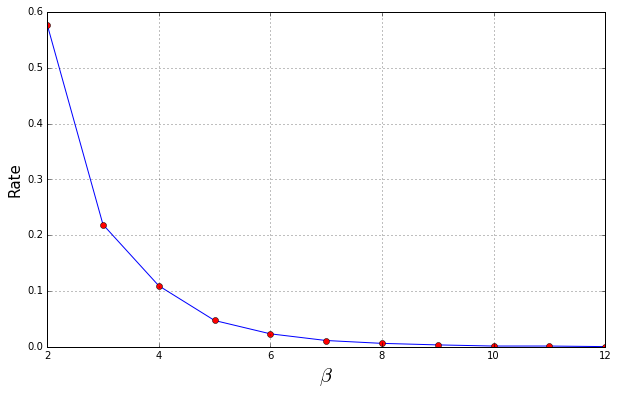

In [7]:
plt.figure(figsize=(10, 6))
ax = plt.subplot(111)
ax.set_xlabel(r'$\beta$', fontsize=20)
ax.set_ylabel('Rate', fontsize=15)
plt.grid(True)
col_sum = rates.sum(axis=0) / total_scales_num
ax.plot(betas, col_sum)
ax.plot(betas, col_sum, 'ro')
plt.show()

# Как часто $k$-й масштаб является устойчивым

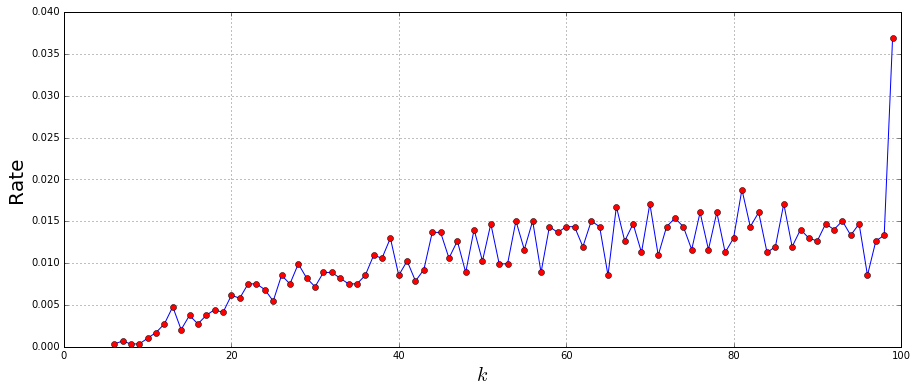

In [8]:
plt.figure(figsize=(15, 6))
plt.subplot()
plt.xlabel('$k$', fontsize=20)
plt.ylabel('Rate', fontsize=20)
plt.grid(True)
row_sum = rates.sum(axis=1) / total_scales_num
plt.plot(scales, row_sum)
plt.plot(scales, row_sum, 'ro')
plt.show()

# Какие $\beta$-устойчивые уровни есть на изображениях

In [9]:
dates = {}
for i, p in enumerate(imagepaths):
    date = re.match('^.+720s\.([0-9]{4})([0-9]{2})([0-9]{2})_.+$', p)
    if date:
        y = date.group(1)
        m = date.group(2)
        d = date.group(3)
        date = '%s-%s-%s' % (y, m, d)
        if date not in dates:
            dates[date] = []
        dates[date].append(i)

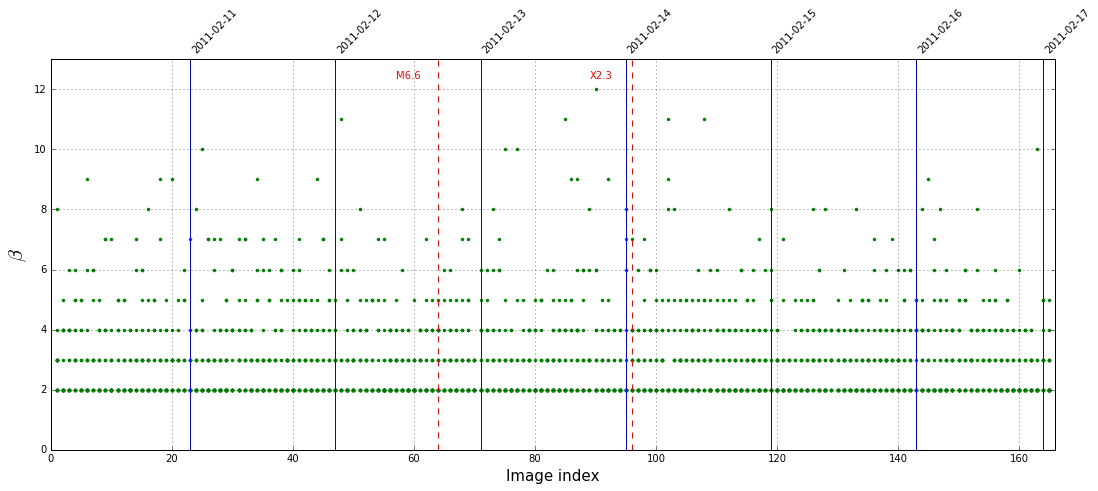

In [10]:
plt.figure(figsize=(18, 7))
ax = plt.subplot(111)
ax.set_xlabel('Image index', fontsize=15)
ax.set_ylabel(r'$\beta$', fontsize=20)
plt.grid(True)
max_beta = 0
for i, lst in enumerate(image_betas):
    betas = [b for s, b in lst]
    max_beta = max(max_beta, max(betas))
    ax.plot([i+1]*len(betas), betas, 'g.')
ax.set_ylim(0, max_beta + 1)
ax.set_xlim(0, len(image_betas) + 1)
cnet.plot_dates(ax, dates, flares, 'b')
plt.show()

Строка — бета-устойчивый уровень, столбец — индекс изображения (т.е. можно увидеть какие есть бета-устойчивые уровни у каждого изображения).

Вертикальные линии обозначают дни (т.е. слева от линии обозначен соответствующий день).

# По каким масштабам размазан $\beta$-й уровень устойчивости

По оси y $\beta$-е уровни устойчивости, по оси x точками обозначены масштабы $s$. Т.е. будет виден разброс по сглаживаниям для каждой устойчивости.

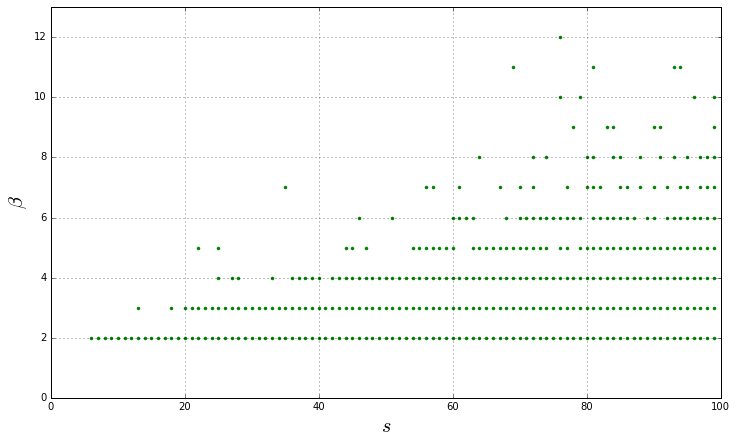

In [11]:
beta_scale_range = {}
for i, scale_beta_pairs in enumerate(image_betas):
    for s, b in scale_beta_pairs:
        if b not in beta_scale_range:
            beta_scale_range[b] = []
        beta_scale_range[b].append(s)

plt.figure(figsize=(12, 7))
plt.subplot()
plt.xlabel(r'$s$', fontsize=20)
plt.ylabel(r'$\beta$', fontsize=20)
plt.ylim(0, max_beta+1)
plt.grid(True)
x, y = [], []
for b, scales in beta_scale_range.items():
    for s in set(scales):
        y.append(b)
        x.append(s)
plt.plot(x, y, 'g.')
plt.show()

# Распределение масштабов в $\beta$-устойчивом уровне

Каждое изображение представляет собой срез по $\beta$ карты частоты встречаемости пар $(s, \beta)$.

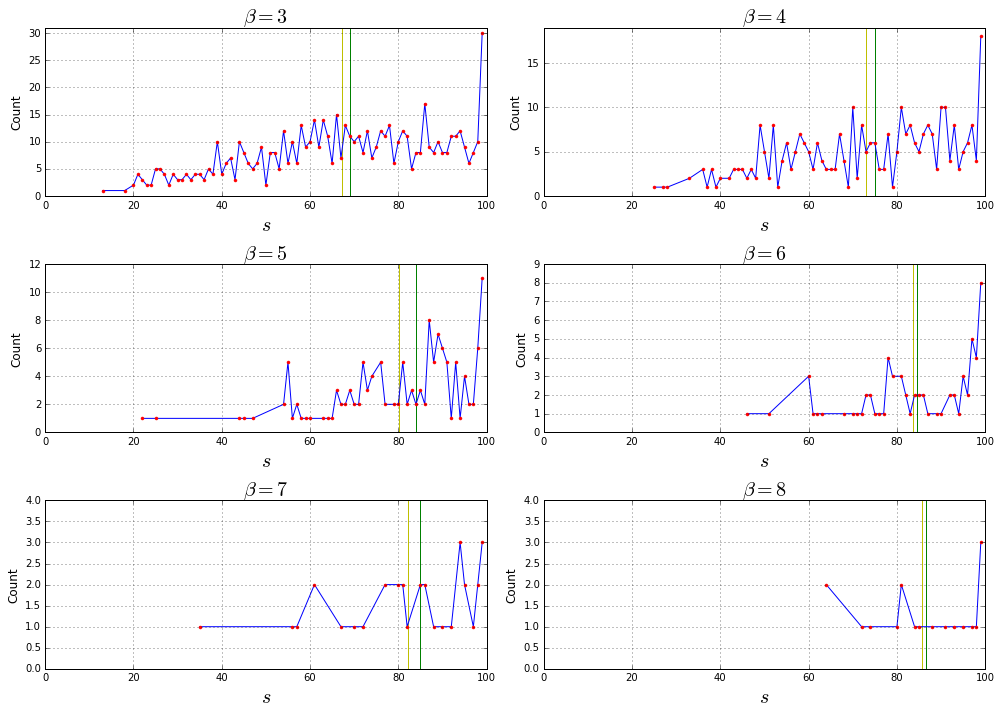

In [12]:
plt.figure(figsize=(14, 10))
for i, (b, scales) in enumerate(beta_scale_range.items()):
    if 2 < b < 9:
        unique, counts = np.unique(scales, return_counts=True)
        plt.subplot(3, 2, i)
        plt.title(r'$\beta=%d$' % b, fontsize=20)
        plt.xlabel('$s$', fontsize=20)
        plt.ylabel('Count', fontsize=12)
        plt.axvline(np.median(scales), color='g')
        plt.axvline(np.mean(scales), color='y')
        plt.ylim(0, max(counts)+1)
        plt.xlim(0, 100)
        plt.grid(True)
        plt.plot(unique, counts, 'b-')
        plt.plot(unique, counts, 'r.')
plt.tight_layout()
plt.show()

## Распределение выбранных масштабов

In [13]:
scales = np.array([x for x, _ in selected_levels])
print('Min scale: %d ' % scales.min())
print('Max scale: %d' % scales.max())
print('Median: %d' % np.median(scales))
print('Mean: %f' % scales.mean())

Min scale: 33 
Max scale: 99
Median: 78
Mean: 75.824242


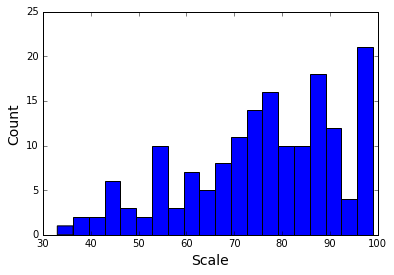

In [14]:
plt.figure()
plt.subplot()
plt.xlabel('Scale', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.hist(scales, 20)
plt.show()

Из гистограммы хорошо видно, что масштабы меняются очень сильно, что влияет на построение графа (меньшее сглаживание — более короткие рёбра, большее сглаживание — более длинные рёбра и б**о**льшая связность). От изображения к изображению граф может кардинально меняться.

## Распределение выбранных уровней устойчивости

In [15]:
betas = np.array([x for _, x in selected_levels])
print('Min scale: %d ' % betas.min())
print('Max scale: %d' % betas.max())
print('Median: %d' % np.median(betas))
print('Mean: %f' % betas.mean())

Min scale: 3 
Max scale: 6
Median: 5
Mean: 5.090909


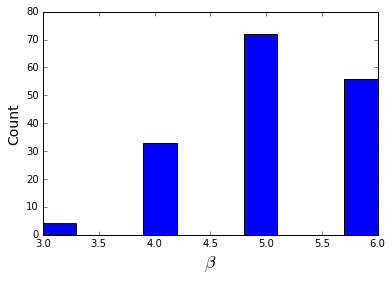

In [16]:
plt.figure()
plt.subplot()
plt.xlabel(r'$\beta$', fontsize=18)
plt.ylabel('Count', fontsize=14)
plt.hist(betas, 10)
plt.show()